In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling as pp
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

In [3]:
scode_list = [
    3626, #TIS
    4307, #オービック
    4684, #野村総合研究所
    4716, #日本オラクル
    4768, #大塚商会
]

etf_list = [

    1309,#上海株式指数・上証50連動型上場投資信託
    #1322,#上場インデックスファンド中国A株（パンダ）CSI300
    1326,#SPDRゴールド・シェア
    1343,#NEXT FUNDS 東証REIT指数連動型上場投信
    1543,#純パラジウム上場信託（現物国内保管型）
    1549,#上場インデックスファンド中国H株（ハンセン中国企業株）
    1551,#JASDAQ-TOP20上場投信
    #1633,#NEXT FUNDS 不動産（TOPIX-17）上場投信
    #1678,#NEXT FUNDS インド株式指数・Nifty 50連動型上場投信
    1681,#上場インデックスファンド海外新興国株式（MSCIエマージング）
    1682,#NEXT FUNDS 日経・東商取白金指数連動型上場投信
    1698,#上場インデックスファンド日本高配当（東証配当フォーカス100）
    9000,#為替　USD/JPY
    9001,#為替　EUR/JPY
]

#上昇／下降率の設定
rate = 0.04

#予測期間
d = 20

#変化率の期間
ch = 20

In [4]:
#2013年からのデータを取り込み
df = pd.read_csv("C:\\Users\\shuhnakano\\Desktop\\ABeam\\25_Python\\株価予測\\stock_list_20181130+為替.csv", engine = 'python')
#為替
#df_usdjpy = pd.read_csv("C:\\Users\\shuhnakano\\Desktop\\ABeam\\25_Python\\株価予測\\USDJPY.csv", engine = 'python')
#df_eurjpy = pd.read_csv("C:\\Users\\shuhnakano\\Desktop\\ABeam\\25_Python\\株価予測\\EURJPY.csv", engine = 'python')

In [5]:
df.columns
df.head(5)

,scode,deal_date,open,high,low,close,volume,trading_value
0,1306,2013/1/4,906.0,909.0,896.0,904.0,5091780.0,904.0
1,1306,2013/1/7,908.0,911.0,895.0,898.0,2783910.0,898.0
2,1306,2013/1/8,894.0,898.0,884.0,887.0,3342470.0,887.0
3,1306,2013/1/9,877.0,899.0,877.0,896.0,3629260.0,896.0
4,1306,2013/1/10,901.0,909.0,899.0,905.0,2825030.0,905.0


In [6]:
#etfデータの補完（マスタ：各銘柄データ）
def CreateDataSet(scode, etf_list, df_org, df):
    df_sc = df.loc[df.scode==scode]
    df_sc.reset_index(drop=True, inplace=True) #concatするためにインデックスをリセット
    
    for etf in etf_list:
        
                
        #データフレームに取得
        df_etf =  df_org.loc[df_org.scode == etf]
        df_etf.reset_index(drop=True, inplace=True) #concatするためにインデックスをリセット
        
        #dates = []
        closeis = []
        for d in df_sc["deal_date"]:
            date = df_etf.loc[(df_etf.deal_date == d), "deal_date"]  # scodeの企業の日付をETFファイルから検索
            close = df_etf.loc[(df_etf.deal_date == d), "close"]  # 日付が一致した日のETFのCloseのデータを取り出す
            
            if len(close) != 0:
                yesterday_close = close.values[0]
                closeis.append(close.values[0])
            else:
                closeis.append(yesterday_close)
    
        
        df_etf2 = pd.DataFrame({"close_" + str(etf): closeis})  # 新しくデータフレームを作成
        df_sc = pd.concat([df_sc, df_etf2], axis=1)  # scodeの企業のデータとETFデータを統合

        #指数平滑化
        df_sc["close_sm_" + str(etf)] = df_sc["close_" + str(etf)].ewm(alpha=0.15).mean()
        df_sc = df_sc.drop(columns="close_" + str(etf))
    
    return df_sc

In [7]:
#説明変数作成(ETF)
def CreateExpVar(scode_list, etf_list, df_org, df):
    df_exp = pd.DataFrame()
    for scode in scode_list:
        df_sc = CreateDataSet(scode, etf_list, df_org, df)
        
        for etf in etf_list:
            #ch営業日前からの変化率
            df_sc["close_diff_" + str(ch) + "_" + str(etf)] = df_sc["close_sm_" + str(etf)].pct_change(ch)
            #前日からの変化率
            #df_sc["close_diff_1_" + str(etf)] = df_sc["close_sm_" + str(etf)].pct_change(1)
        
        df_exp = pd.concat([df_exp, df_sc], axis=0)
    df_exp = df_exp.reset_index(drop=True) #結合用にインデックスの値をリセット
    
    return df_exp

In [8]:
#グラフ検証
#df_exp.loc[df_exp['scode']==4307, 'close_sm_9000']
#a = df_exp[df_exp['scode']==4307].reset_index(drop=True)
#b = df[df.scode==9000].reset_index(drop=True)
#plt.plot(a['close_sm_9000'])
#plt.plot(b['close'])

#a = df_exp[df_exp['scode']==4307].reset_index(drop=True)
#b = df[df.scode==9000].reset_index(drop=True)
#plt.plot(a['close_sm_9000'])
#plt.plot(b['close'])



In [9]:
df_exp = CreateExpVar(scode_list, etf_list, df, df)
df_exp.shape

(7240, 30)

In [10]:
#目的変数の作成
def CreateObjVar(scode_list, df):
    df_obj = pd.DataFrame()
    for scode in scode_list:
        df_sc2 = df.loc[df.scode==scode]
                
        #df_sc2["change_rate_" + str(d)] = df_sc2["trading_value"].pct_change(-d)
        #d営業日後の終値と今日の終値の変化率
        df_sc2["change_rate_" + str(d)] = -df_sc2["trading_value"].diff(-d) / df_sc2["trading_value"]
        
        #目的変数の設定
        df_sc2["obj"] = 0
        df_sc2.loc[df_sc2["change_rate_" + str(d)] > rate, "obj"] = 1
        df_sc2.loc[df_sc2["change_rate_" + str(d)] < -rate, "obj"] = -1
        
        df_obj = pd.concat([df_obj, df_sc2], axis=0)
            
    df_obj = df_obj.reset_index(drop=True) #結合用にインデックスの値をリセット
    
    return df_obj

In [11]:
df_obj = CreateObjVar(scode_list, df)
df_obj.shape

C:\Users\shuhnakano\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\shuhnakano\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\shuhnakano\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

(7240, 10)

In [12]:
#df_ds = df_exp.join(df_obj.loc[:, 'obj'], )
df_ds = pd.concat([df_exp, df_obj], axis=1, join_axes=[df_exp.index])
#NaNの行を除外
df_ds = df_ds.dropna(how='any')
#df_ds.shape
df_ds.head(50)

,scode,deal_date,open,high,low,close,volume,trading_value,close_sm_1309,close_sm_1326,...,scode,deal_date,open,high,low,close,volume,trading_value,change_rate_20,obj
20,3626,2013/2/4,1304.0,1316.0,1283.0,1315.0,317300.0,1315.0,21739.823858,14685.001588,...,3626,2013/2/4,1304.0,1316.0,1283.0,1315.0,317300.0,1315.0,-0.020532,0
21,3626,2013/2/5,1171.0,1189.0,1083.0,1110.0,2215900.0,1110.0,21926.580158,14733.612642,...,3626,2013/2/5,1171.0,1189.0,1083.0,1110.0,2215900.0,1110.0,0.137838,1
22,3626,2013/2/6,1130.0,1163.0,1082.0,1093.0,2141800.0,1093.0,22154.518803,14803.740001,...,3626,2013/2/6,1130.0,1163.0,1082.0,1093.0,2141800.0,1093.0,0.152790,1
23,3626,2013/2/7,1103.0,1124.0,1078.0,1084.0,1130600.0,1084.0,22259.464315,14867.468399,...,3626,2013/2/7,1103.0,1124.0,1078.0,1084.0,1130600.0,1084.0,0.166974,1
24,3626,2013/2/8,1081.0,1110.0,1068.0,1097.0,939700.0,1097.0,22329.753488,14901.432243,...,3626,2013/2/8,1081.0,1110.0,1068.0,1097.0,939700.0,1097.0,0.135825,1
25,3626,2013/2/12,1098.0,1113.0,1087.0,1098.0,460200.0,1098.0,22401.336881,14910.347735,...,3626,2013/2/12,1098.0,1113.0,1087.0,1098.0,460200.0,1098.0,0.096539,1
26,3626,2013/2/13,1100.0,1123.0,1100.0,1110.0,840100.0,1110.0,22431.511278,14904.219428,...,3626,2013/2/13,1100.0,1123.0,1100.0,1110.0,840100.0,1110.0,0.070270,1
27,3626,2013/2/14,1100.0,1119.0,1090.0,1106.0,564900.0,1106.0,22472.214477,14902.063746,...,3626,2013/2/14,1100.0,1119.0,1090.0,1106.0,564900.0,1106.0,0.097649,1
28,3626,2013/2/15,1090.0,1090.0,1043.0,1065.0,525100.0,1065.0,22450.689064,14863.911679,...,3626,2013/2/15,1090.0,1090.0,1043.0,1065.0,525100.0,1065.0,0.123944,1
29,3626,2013/2/18,1072.0,1132.0,1072.0,1108.0,356600.0,1108.0,22461.165649,14836.112801,...,3626,2013/2/18,1072.0,1132.0,1072.0,1108.0,356600.0,1108.0,0.031588,0


In [20]:
X = df_ds.loc[:, df_ds.columns.str.contains('diff')] #説明変数のみ
Y = df_ds.loc[:, df_ds.columns.str.contains('obj')] #目的変数のみ

In [21]:
#print(X.head(5))
#print(Y.head(5))
print(X.shape)
print(Y.shape)

(7040, 11)
(7040, 1)


In [22]:
#Y = Y[Y['Obj'] != 0] #1かー1の2クラス

In [23]:
Y = Y.values #目的変数をnumpy配列形式に変換

In [42]:
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, Y, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=0)

print(X_trainval.shape)
print(X_test.shape)
print(X_train.shape)
print(X_valid.shape)
print(y_trainval.shape)
print(y_test.shape)
print(y_train.shape)
print(y_valid.shape)

(5280, 11)
(1760, 11)
(3960, 11)
(1320, 11)
(5280, 1)
(1760, 1)
(3960, 1)
(1320, 1)


In [66]:
#X_train_2 = X_train_2.astype(float) #文字列をFloatに変換
#X_test_2 = X_test_2.astype(float) #文字列をFloatに変換
X_train = X_train.astype(float) #文字列をFloatに変換
X_test = X_test.astype(float) #文字列をFloatに変換
X_valid = X_valid.astype(float) #文字列をFloatに変換
X = X.astype(float) #文字列をFloatに変換

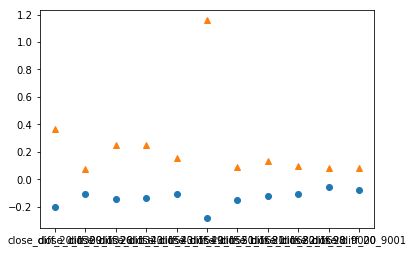

In [44]:
plt.plot(X_train.min(axis=0), 'o', label="min")
plt.plot(X_train.max(axis=0), '^', label="max")

In [67]:
#説明変数の標準化
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_valid)
X_trainval_scaled = scaler.transform(X_trainval)
X_scaled = scaler.transform(X)

In [68]:
print(np.average(X_train_scaled))
print(np.var(X_train_scaled))
print(np.average(X_test_scaled))
print(np.var(X_test_scaled))
print(np.average(X_valid_scaled))
print(np.var(X_valid_scaled))
print(np.average(X_trainval_scaled))
print(np.var(X_trainval_scaled))
print(np.average(X_scaled))
print(np.var(X_scaled))

4.0779541767682516e-18
0.9999999999999998
0.014705698286336017
1.0413517229466371
0.006700958197998542
1.0581182294342037
0.0016752395494996379
1.0145379766411955
0.004932854233708733
1.0212732493778482


In [63]:
#ハイパーパラメータの設定
kernel = 'rbf'
best_score = 0
"""
#グリッドサーチ（ホールドアウト法）
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svc_sc = SVC(kernel='rbf', gamma=gamma, C=C)
        #svc_sc_cl = OneVsRestClassifier(svc_sc)
        svc_sc.fit(X_train_scaled, y_train.ravel()) #スケール（平均値0, 分散1）した訓練データに対して、one-versus-the-oneで予測モデルを作成
        #svc_sc_cl.fit(X_train_scaled, y_train.ravel()) #スケール（平均値0, 分散1）した訓練データに対して、One-versus-the-restで予測モデルを作成
        score = svc_sc.score(X_valid_scaled, y_valid)
        
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
        
        
svc_sc = SVC(**best_parameters)
svc_sc.fit(X_trainval_scaled, y_trainval)
test_score = svc_sc.score(X_test_scaled, y_test)

#one-versus-the-one
print("ベストスコア：" + format(best_score))
print("ベストスコアのパラメータ" + format(best_parameters))
print("テストセットのスコア" + format(test_score))
"""

#グリッドサーチ（交差検証）
for gamma in [0.1, 1, 10]:
    for C in [0.1, 1, 10]:
        svc_sc = SVC(kernel='rbf', gamma=gamma, C=C)
        #svc_sc_cl = OneVsRestClassifier(svc_sc)
        scores = cross_val_score(svc_sc, X_trainval_scaled, y_trainval.ravel(), cv=5)
        #svc_sc_cl.fit(X_train_scaled, y_train.ravel()) #スケール（平均値0, 分散1）した訓練データに対して、One-versus-the-restで予測モデルを作成
        score = np.mean(scores)
        
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
        
        
svc_sc = SVC(**best_parameters)
svc_sc.fit(X_trainval_scaled, y_trainval.ravel())
test_score = svc_sc.score(X_test_scaled, y_test.ravel())

#one-versus-the-one
print("ベストスコア：" + format(best_score))
print("ベストスコアのパラメータ" + format(best_parameters))
print("テストセットのスコア" + format(test_score))


ベストスコア：0.6019026594052197
ベストスコアのパラメータ{'C': 10, 'gamma': 0.1}
テストセットのスコア0.6085227272727273


In [69]:
svc_sc_pre = svc_sc.predict(X_test_scaled)
svc_sc_pre_all = svc_sc.predict(X_scaled)
print(svc_sc.predict(X_test_scaled)[0:200])
print(y_test.ravel()[0:200])

[ 0  1  0  1  1  0  1  0  1  1  1  0  0 -1  0  0  1  0  1 -1  1  0  1  1
  1  1  0  1  1  0  0  0  0  0 -1  1 -1  1  1  0  0  1  0  1  0  0  1  1
  1 -1  0  0  0  0  0  1  0  1 -1 -1  1  1 -1  1  0  1  1  0  1  0  0 -1
  0  1 -1 -1 -1  0  0  1  1  1  1  0  1  0  1  1 -1  0  0  0  0  1  1 -1
 -1  1 -1  1  0  1  0 -1  0  0  0  0  1  1  1  1  0  1  1  1  1 -1  0  1
 -1  1  0  1 -1  0  0 -1  1  1  0  1 -1  0  1  0  1  0 -1  0  0  0 -1  0
  1  1  1 -1  1  1  0  1  0  1  0  1  0  0  1  1  0  0  0  0  0  0 -1  1
  0  0  0  1  0  1  0  0  0 -1  1  1 -1 -1 -1  1  1  1  1  1  1  1  0  1
  1 -1  1  0  1  1  1  1]
[ 0  1 -1  1 -1  0  0  0  1  1  1  1  1 -1  1 -1  1  0 -1  0  0  0  1  0
  0  1  1  1  1 -1 -1  1  0  0 -1  1 -1  0  1  1  1  0  0  1  0  0  1  1
  1 -1  0  0  0  0  0  1 -1  1 -1 -1  1  1 -1  0  0  1  1 -1  0  1  0 -1
 -1  1 -1 -1 -1  0  0  1  0  1  1  0  1  0  0  1 -1  1  0  1  0 -1  1 -1
 -1  1 -1  0 -1  0  0 -1  1 -1 -1  1  1  1  1  1 -1  1  1  0  1 -1  0  1
 -1  1  0  1  1  0  0 -1 

In [65]:
cm = confusion_matrix(y_test, svc_sc_pre)
prfs = precision_recall_fscore_support(y_test, svc_sc_pre) #結果はクラス順（-1, 0, 1)
print(cm)
print(prfs)
print(sum(sum(cm)))

[[182 126  53]
 [ 78 448 211]
 [ 16 205 441]]
(array([0.65942029, 0.57509628, 0.62553191]), array([0.50415512, 0.60786974, 0.66616314]), array([0.57142857, 0.59102902, 0.64520849]), array([361, 737, 662], dtype=int64))
1760


In [70]:
cm_all = confusion_matrix(Y, svc_sc_pre_all)
prfs_all = precision_recall_fscore_support(Y, svc_sc_pre_all) #結果はクラス順（-1, 0, 1)
print(cm_all)
print(prfs_all)
print(sum(sum(cm_all)))

[[ 712  481  220]
 [ 291 1846  769]
 [  82  776 1863]]
(array([0.6562212 , 0.59490815, 0.65322581]), array([0.50389243, 0.63523744, 0.68467475]), array([0.57005604, 0.61441172, 0.66858066]), array([1413, 2906, 2721], dtype=int64))
7040
